# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

# II. Maze Problem

Describe the problem. Read the following code and explain the GridWorld environment. 

In [1]:
import math
import collections
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
file = open("grid.txt", "r")
data = file.read()
print(data)

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOGOOO
OOOOOOOOO


In [3]:
# maze example

debug = False
verbose = False


class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up
            
            my change
            ---------
            
            print env.next(0)  # left
            print env.next(1)  # right
            print env.next(2)  # up
            print env.next(3)  # down

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def set_cur_state(self,s):
        self._s=s
    
    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state
            
        if self.check_state(s) == 'O':
            #self._s = np.asarray(state)
            self._s = np.asarray(s)
        else:
            raise ValueError("Invalid state for init")
        

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    #Method to check if the current state is a goal state
    def goal_reached(self):
        if(self._s is not None and self._s[0]==self.goal_pos[0] and self._s[1]==self.goal_pos[1]):
            return True
        else:
            return False
        
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'G' 'O' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your approach and the reason why you select it.
- Add epsilon_greedy function and explain it.
- Explain your codes.

In [7]:
#This method will return true only with a given probaility 

def selectRandomAction(epsilon):
    return np.random.uniform()<epsilon

#A method to get the values of v for a given state
def get_Q(s,a):
    return Q[s[0],s[1],a]

#A method to set a V value for a given state
def set_Q(s,a,q):
    Q[s[0],s[1],a]=q

#Method to choose action from a state s using the estimated Q values wit epsilon-greedy
def epsilon_greedy_action(env,Q,s,epsilon=0.01):
    greedy_action=None
    
    maxQ=np.max(Q[s[0],s[1]])
    
    eqaualMax=np.where(Q[s[0],s[1]] == maxQ)[0]
    
    action=np.random.choice(eqaualMax)
    
    if(selectRandomAction(epsilon)):
        action=np.random.randint(4)
    
    return action

## SARSA

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

#A method to learn best way to find the goal
def learn_find_goal(env,Q,epsilon,alpha,gamma):
    steps=1;
    states=[]
    total_reward=0
    current_state=env.get_cur_state()
    a=epsilon_greedy_action(env,Q,current_state,epsilon)
    #Add the cureent state to the path
    while(not env.goal_reached()):
        states.append(current_state)
        r=env.next(a)
        total_reward+=r
        next_state=env.get_cur_state()
        
        a_new=epsilon_greedy_action(env,Q,next_state,epsilon)
        #since the state has already been updated
        new_Q=get_Q(current_state,a)+alpha*(r+gamma*(get_Q(next_state,a_new)-get_Q(current_state,a)))
        #update the new V value for this state
        set_Q(current_state,a,new_Q)
        
        #update the state action pair
        current_state=next_state
        a=a_new
        
        steps=steps+1
        
    #new_Q=get_Q(current_state,a)+alpha*(r-get_Q(current_state,a))
    set_Q(current_state,a,0) #for terminal state
    states.append(env._s)
    return states,total_reward

## Training the agent

In [22]:
import time
#initialize the Q's for each state
Q=np.zeros((env._size[0],env._size[1],len(env._actions)))
env.init()
epoch_limit=2000
alpha=0.01
gamma=0.9
epsilon=0.01;
rewards=[]
steps=np.zeros([epoch_limit+1,1])
for epoch in range(1,epoch_limit+1):
    epsilon=epsilon-0.01*epsilon
    env.init([0,0])
    epoch_start_time=time.clock()
    states_reward=learn_find_goal(env,Q,epsilon,alpha,gamma) #returns states and reward 
    states=states_reward[0]
    rewards.append(states_reward[1])
    steps[epoch]=len(states)
    epoch_end_time=time.clock()

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Plot 4 plots (see the image): 
  - the sum of rewards per episode
  - the number of steps per episode
  - contour plot of Q 
  - the trajectory of solution by using the learned policy

$\gamma$: Kept the discounting factor high so that taking steps are not that penalized.<br>
$\alpha$: Kept the learning constant at a small value so that the the model shoulld convegre gradually and does not keep hoping around the optimum.
$\epsilon$: Keep reducing the epsilon after each epoch so that as the agent becomes more confidence about the environment it follows chooses the best path mostly rather then trying random path.

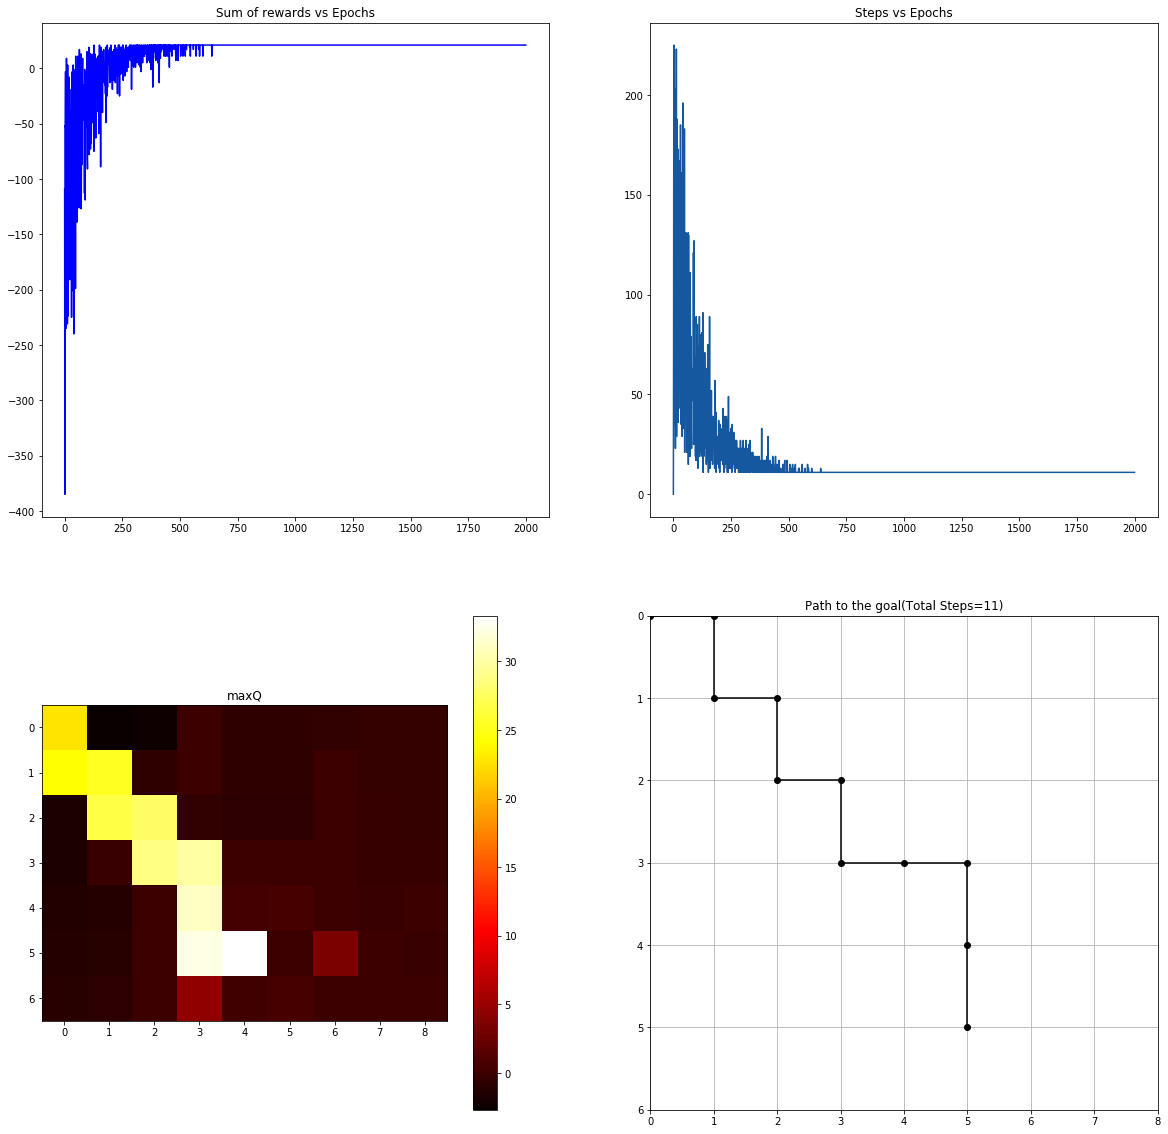

In [24]:
def plot_data(states,rewards,Q,steps):
    x=[]
    y=[]
    z=[]
    state_count=0
    for state in states:
        x.append(state[0])
        y.append(state[1])
        z.append(state_count)
        state_count=state_count+1
    
   
    f, ((ax1, ax2),(ax3,ax4))=plt.subplots(2, 2,figsize=(20,20))
    
    ax1.plot(rewards,marker='', color='blue')
    ax1.set_title("Sum of rewards vs Epochs")
    
    ax2.plot(steps,marker='', color='#1658a0')
    ax2.set_title("Steps vs Epochs")
    
    heatmap =ax3.imshow(np.max(Q,axis=2), cmap='hot', interpolation='nearest')
    ax3.set_title("maxQ")
    ax3.grid(False)
    
    f.colorbar(heatmap,ax=ax3)
    
    ax4.plot(x,y,marker='o', color='black')
    ax4.grid(True)
    ax4.axis([0, 8, 6, 0])
    title="Path to the goal(Total Steps="+str(len(states))+")"
    ax4.set_title(title)

plot_data(states,rewards,Q,steps)